**@author: James V. Talwar**

# HLA Alleles and Age at Diagnosis: Individual Allele Association Investigation

**About**: This notebook provides the code needed to generate **Supplementary Figure 10** and relevant analyses from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). These analyses investigated the effect of individual HLA allele associations with age of melanoma diagnosis in both discovery (TCGA skin cutaneous melanoma cases) and validation cohorts. 

## 1. Import Packages; Load Data

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
import tqdm
from itertools import combinations
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in TCGA summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [3]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

#add a column "Alleles" with a composite list of class-I alleles for each individual 
tcgaSummary["Alleles"] = [list(row["A1":"C2"]) for i,row in tcgaSummary.iterrows()]

Load in validation cohort summary dataframe (MHC-I genotypes, Age of Diagnosis, Sex, etc.):

In [4]:
fullyResolvedValidation = pd.read_csv("../GenotypeData/Validation_Fully_Resolved.tsv", sep = "\t", index_col = 0)

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
fullyResolvedValidation = fullyResolvedValidation[fullyResolvedValidation.AgeAtDiagnosis >= 20]

#Sanity check AI allele status:
if not (list(fullyResolvedValidation["HasProtection"].astype(bool)) == [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in fullyResolvedValidation.iterrows()]):
    raise ValueError("Autoimmune Protection Assignment Disagreement")
    
#add a column "Alleles" with a composite list of class-I alleles for each individual 
fullyResolvedValidation["Alleles"] = [list(row["A1":"C2"]) for i,row in fullyResolvedValidation.iterrows()]

## 2. Data Processing, Formatting, and Statistical Analyses: 

Get the set of alleles for investigation (i.e., those class I alleles found in both discovery and validation cohorts):

In [5]:
discoveryAlleles = set([el for i,row in tcgaSummary.iterrows() for el in row["A1": "C2"]])
print("{} unique class-I alleles found in discovery cohort.".format(len(discoveryAlleles)))

validationAlleles = set([el for i,row in fullyResolvedValidation.iterrows() for el in row["A1": "C2"]])
print("{} unique class-I alleles found in validation cohort.".format(len(validationAlleles)))

#get the intersection of unique alleles (i.e., those alleles that are found in both cohorts)
allelesForInvestigation = discoveryAlleles.intersection(validationAlleles)
print("{} unique class-I alleles found in both cohorts. These will be used in downstream analysis.".format(len(allelesForInvestigation)))

118 unique class-I alleles found in discovery cohort.
340 unique class-I alleles found in validation cohort.
96 unique class-I alleles found in both cohorts. These will be used in downstream analysis.


Define function(s) to calculate cohort specific effects:

In [6]:
'''
Inputs: 
    1) discoverData - pandas dataframe containing age and MHC-I genotype
    2) validationData - pandas dataframe containing age and MHC-I genotype
    3) allelesToInvestigate - set of unique class-I alleles that exist in both discoverData and validationData
    4) upperLimit - number of unique combinations of alleles to partition cohorts by (default: 1 - i.e, looking at single allele effects). 
                    This will extract all unique combinations of alleles continuously from 1 to the number of alleles under investigation. 

Output:
    toReturn - a dictionary mapping statistical results of allele combination stratification
'''
def CalculateAgeEffects(discoverData = tcgaSummary, validationData = fullyResolvedValidation, allelesToInvestigate = allelesForInvestigation, upperLimit = 1):
    #Get all the unique combinations:
    combos = list()
    for i in range(1, upperLimit + 1):
        combos += list(combinations(allelesToInvestigate, i))
    
    toReturn = defaultdict(lambda: defaultdict(float))
    
    for combo in tqdm.tqdm(combos):
        discoverHasCombo = discoverData[discoverData["Alleles"].apply(lambda x: len(set(combo).intersection(set(x))) >= 1)]
        discoverNoCombo = discoverData[~discoverData["Alleles"].apply(lambda x: len(set(combo).intersection(set(x))) >= 1)] 
        
        stat,pDisc = mannwhitneyu(discoverHasCombo.Age, discoverNoCombo.Age)
        discMedianAgeDiff = np.median(discoverHasCombo.Age) - np.median(discoverNoCombo.Age)
        
        toReturn[combo]["pDiscovery"] = pDisc
        toReturn[combo]["discoveryMedianAgeDifference"] = discMedianAgeDiff
        toReturn[combo]["DiscoveryWithAllele"] = discoverHasCombo.shape[0]
        
        valHasCombo = validationData[validationData["Alleles"].apply(lambda x: len(set(combo).intersection(set(x))) >= 1)] 
        valNoCombo = validationData[~validationData["Alleles"].apply(lambda x: len(set(combo).intersection(set(x))) >= 1)] 
        
        stat,pVal = mannwhitneyu(valHasCombo.AgeAtDiagnosis, valNoCombo.AgeAtDiagnosis)
        valMedianAgeDiff = np.median(valHasCombo.AgeAtDiagnosis) - np.median(valNoCombo.AgeAtDiagnosis)
        
        toReturn[combo]["pVal"] = pVal
        toReturn[combo]["validationMedianAgeDifference"] = valMedianAgeDiff
        toReturn[combo]["ValidationWithAllele"] = valHasCombo.shape[0]
       
    print("Total number of allele combinations processed: {}".format(len(combos)))
    return toReturn

Run class-I allele specific associations:

In [7]:
combinationResults = CalculateAgeEffects()
whatAreTheComboResults = pd.DataFrame(combinationResults).T.dropna()
whatAreTheComboResults = whatAreTheComboResults.sort_values(by=["pDiscovery"], ascending = True)

100%|██████████| 96/96 [00:00<00:00, 159.47it/s]


Total number of allele combinations processed: 96


Correct p-values for both cohorts (MH-testing):

In [8]:
correctedPDiscoveryResults = multipletests(pvals = whatAreTheComboResults.pDiscovery, alpha = 0.1, method = "fdr_bh")
correctedPValidationResults = multipletests(pvals = whatAreTheComboResults.pVal, alpha = 0.1, method = "fdr_bh")

whatAreTheComboResults["correctedPDiscovery"] = correctedPDiscoveryResults[1]
whatAreTheComboResults["correctedPVal"] = correctedPValidationResults[1]

print("There are {} significant hits after correction in the discovery set.".format(sum(correctedPDiscoveryResults[0])))
print("There are {} significant hits after correction in the validation set.".format(sum(correctedPValidationResults[0])))

There are 0 significant hits after correction in the discovery set.
There are 0 significant hits after correction in the validation set.


Are there any alleles that are significant (pre-correction) across cohorts and show the same direction of age difference?

In [9]:
doubleSignificantHits = whatAreTheComboResults[(whatAreTheComboResults["pDiscovery"] <= 0.05)&(whatAreTheComboResults["pVal"] <= 0.05)&(whatAreTheComboResults.discoveryMedianAgeDifference*whatAreTheComboResults.validationMedianAgeDifference > 0)]
doubleSignificantHits

,pDiscovery,discoveryMedianAgeDifference,DiscoveryWithAllele,pVal,validationMedianAgeDifference,ValidationWithAllele,correctedPDiscovery,correctedPVal
HLA-B27:02,0.049627,-10.0,15.0,0.033234,-11.3,3.0,0.483474,0.387736


## 3. Generate Figure:

Iterate through all single alleles that are interesting pre-MH correction since none are significant (in this case is just HLA-B*27:02) and generate figure(s):

Sanity Checking Results:

p discovery (uncorrected) = 0.04962667269205269
Discovery median age difference is -10.0

p validation (uncorrected) = 0.03323422159737641
Validation median age difference is -11.299999999999997



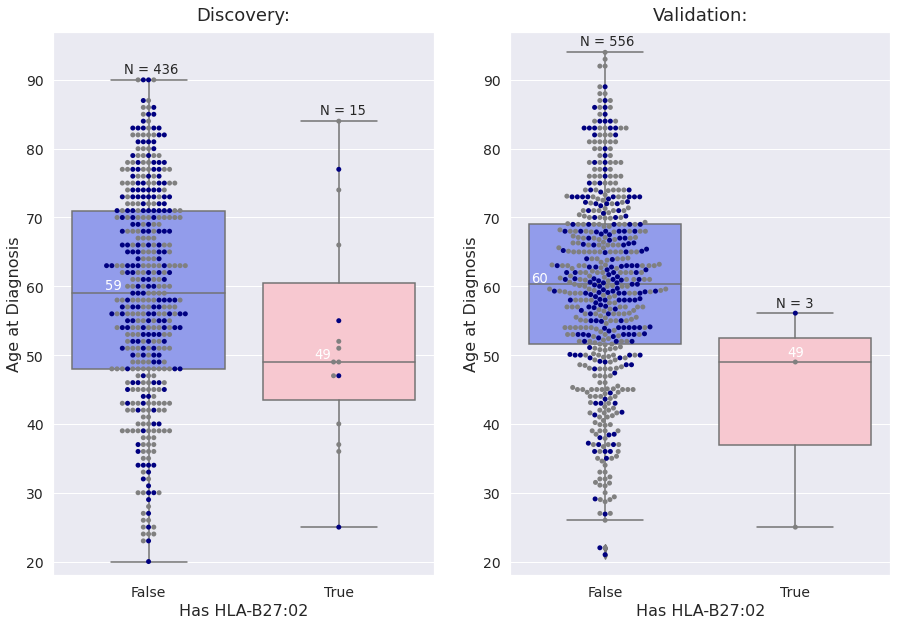

In [18]:
interestingAllelesToVisualize = set([el for el in doubleSignificantHits.index])

sns.set(font_scale = 1.1)
fig, axs = plt.subplots(doubleSignificantHits.shape[0],2, figsize = (15, 10)) #number of hits one plot each for Disc and Val
xPlot = 0
yPlot = 0
palette = {True: "pink", False: '#8390FA'}
protectionPalette = {True: "navy", False: "grey"}
for allele in interestingAllelesToVisualize:
    discoverHasAllele = tcgaSummary[tcgaSummary["Alleles"].apply(lambda x: len(set(allele).intersection(set(x))) >= 1)]
    discoverNoAllele = tcgaSummary[~tcgaSummary["Alleles"].apply(lambda x: len(set(allele).intersection(set(x))) >= 1)]
    valHasAllele = fullyResolvedValidation[fullyResolvedValidation["Alleles"].apply(lambda x: len(set(allele).intersection(set(x))) >= 1)]
    valNoAllele = fullyResolvedValidation[~fullyResolvedValidation["Alleles"].apply(lambda x: len(set(allele).intersection(set(x))) >= 1)]
    
    stat,pDisc = mannwhitneyu(discoverHasAllele.Age, discoverNoAllele.Age)
    discMedianAgeDiff = np.median(discoverHasAllele.Age) - np.median(discoverNoAllele.Age)
    
    stat,pVal = mannwhitneyu(valHasAllele.AgeAtDiagnosis, valNoAllele.AgeAtDiagnosis)
    valMedianAgeDiff = np.median(valHasAllele.AgeAtDiagnosis) - np.median(valNoAllele.AgeAtDiagnosis)
    
    key = "Has {}".format(allele[0])
    
    #Seaborn requirement
    tempDisc = tcgaSummary.copy()
    tempDisc[key] = list(tcgaSummary["Alleles"].apply(lambda x: len(set(allele).intersection(set(x))) >= 1))
    tempVal = fullyResolvedValidation.copy()
    tempVal[key] = list(fullyResolvedValidation["Alleles"].apply(lambda x: len(set(allele).intersection(set(x))) >= 1))

    print("Sanity Checking Results:\n")
    print("p discovery (uncorrected) = {}".format(pDisc))
    print("Discovery median age difference is {}\n".format(discMedianAgeDiff))
    print("p validation (uncorrected) = {}".format(pVal))
    print("Validation median age difference is {}\n".format(valMedianAgeDiff))
    if doubleSignificantHits.shape[0] == 1: 
        sns.boxplot(data = tempDisc, x = key, y = "Age", ax = axs[xPlot], palette=palette)
        sns.swarmplot(data = tempDisc, x = key, y = "Age", hue = "HasProtection", ax = axs[xPlot], palette = protectionPalette)
        axs[xPlot].set_title("Discovery:", fontsize = 18, y = 1.01) 
        axs[xPlot].legend([], [], frameon = False)
        
        sns.boxplot(data = tempVal, x = key, y = "AgeAtDiagnosis", ax = axs[xPlot + 1], palette = palette)
        sns.swarmplot(data = tempVal, x = key, y = "AgeAtDiagnosis", hue = "HasProtection", ax = axs[xPlot + 1], palette = protectionPalette)
        axs[xPlot+1].legend([], [], frameon = False) 
        axs[xPlot + 1].set_title("Validation:", fontsize = 18, y = 1.01) 
        
        axs[xPlot].set_xlabel("Has {}".format(allele[0]), fontsize = 16)
        axs[xPlot].set_ylabel("Age at Diagnosis", fontsize = 16)
        
        #increase the size of the tickmarks
        axs[xPlot].tick_params(labelsize = 14)
        axs[xPlot+1].tick_params(labelsize = 14)
        
        axs[xPlot].text(-0.23,59.6, int(np.median(discoverNoAllele.Age)), color = "white")
        axs[xPlot].text(0.87,49.6, int(np.median(discoverHasAllele.Age)), color = "white")
        axs[xPlot].text(-0.13, 91, f"N = {discoverNoAllele.shape[0]}")
        axs[xPlot].text(0.9, 85, f"N = {discoverHasAllele.shape[0]}")
        
        axs[xPlot+1].set_xlabel("Has {}".format(allele[0]), fontsize = 16)
        axs[xPlot+1].set_ylabel("Age at Diagnosis", fontsize = 16)
        axs[xPlot+1].text(-0.39,60.6, int(np.median(valNoAllele.AgeAtDiagnosis)), color = "white")
        axs[xPlot+1].text(0.96,49.9, int(np.median(valHasAllele.AgeAtDiagnosis)), color = "white")
        axs[xPlot+1].text(-0.13, 95, f"N = {valNoAllele.shape[0]}")
        axs[xPlot+1].text(0.9, 57, f"N = {valHasAllele.shape[0]}")
        
        #Make sure plotted on the same scale
        axs[xPlot].set_ylim(18, 97)
        axs[xPlot+1].set_ylim(18, 97)
        
    else: #This condition plotting/visualization code should be sanity checked: 
        
        sns.boxplot(data = tempDisc, x = key, y = "Age", ax = axs[xPlot, yPlot], palette= palette)
        sns.swarmplot(data = tempDisc, x = key, y = "Age", ax = axs[xPlot, yPlot], dodge = True, color = "grey")
        axs[xPlot, yPlot].set_title("Discovery (TCGA): {}".format(allele[0]))
        axs[xPlot, yplot].set_xlabel("Has {}".format(allele[0]), fontsize = 16)
        axs[xPlot, yplot].set_ylabel("Age at Diagnosis", fontsize = 16)
        
        sns.boxplot(data = tempVal, x = key, y = "AgeAtDiagnosis", ax = axs[xPlot, yPlot + 1], palette = palette)
        sns.swarmplot(data = tempVal, x = key, y = "AgeAtDiagnosis", ax = axs[xPlot, yPlot + 1], dodge = True, color = "grey")
        axs[xPlot, yPlot + 1].set_title("Validation: {}".format(allele[0]))
        axs[xPlot, yplot + 1].set_xlabel("Has {}".format(allele[0]), fontsize = 16)
        axs[xPlot, yplot + 1].set_ylabel("Age at Diagnosis", fontsize = 16)

        xPlot += 1